In [1]:
import blosc2
import numpy as np
import archetypes as arch

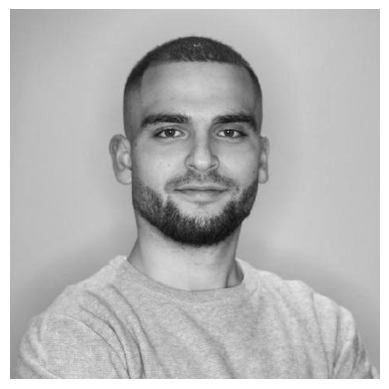

In [38]:
import cv2

img = cv2.imread("C:/Users/aalcacer/Projects/biaa-codec/profile.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (2048, 2048), interpolation=cv2.INTER_CUBIC).astype(np.float64)

import matplotlib.pyplot as plt

plt.imshow(img, cmap="gray")
plt.axis('off')
plt.show()


In [39]:
def tile_img(img, tile_shape):
    img = img.reshape(img.shape[0] // tile_shape[0], tile_shape[0], img.shape[1] // tile_shape[1], tile_shape[1])
    img = img.swapaxes(1, 2)
    img = img.reshape(-1, tile_shape[0] * tile_shape[1])
    return img

def untile_img(img, img_shape, tile_shape):
    img = img.reshape(img_shape[0] // tile_shape[0], img_shape[1] // tile_shape[1], tile_shape[0], tile_shape[1])
    img = img.swapaxes(1, 2)
    img = img.reshape(img_shape)
    return img



In [57]:
tile_size = 4

img_tiled = tile_img(img, (tile_size, tile_size))

print(img_tiled.shape)

k = 6

model = arch.AA(k, max_iter=100, tol=1e-5, n_init=3, verbose=True)
img_sampled = img_tiled[np.random.choice(img_tiled.shape[0], 1000, replace=False)]
model.fit(img_sampled)

archetypes = model.archetypes_

(262144, 16)
Initialization 1/3
    Iteration:   1, RSS: inf
Initialization 2/3
    Iteration:   1, RSS: inf
Initialization 3/3
    Iteration:   1, RSS: inf


In [69]:
import pickle

def encoderAA(input, output, meta, schunk: blosc2.SChunk):
   model = pickle.loads(schunk.meta['archetypes'])

   b2nd_meta = schunk.meta['b2nd']
   dtype = np.dtype(b2nd_meta[6])

   blocks = b2nd_meta[4]

   img = input.view(dtype=dtype).reshape(blocks)

   img = tile_img(img, (meta, meta))

   alphas = model.transform(img)
   
   threshold_values = np.arange(256) / 255  # 256 values between 0 and 1
   alphas = np.argmin(np.abs(alphas[:, :, None] - threshold_values[None, None, :]), axis=2)
   alphas = alphas.astype(np.uint8)
   alphas_serialized = pickle.dumps(alphas)
   output[:len(alphas_serialized)] = np.frombuffer(alphas_serialized, dtype=np.uint8)
   return len(alphas_serialized)


In [70]:
def decoderAA(input, output, meta, schunk: blosc2.SChunk):
    model = pickle.loads(schunk.meta['archetypes'])

    b2nd_meta = schunk.meta['b2nd']
    dtype = np.dtype(b2nd_meta[6])

    blocks = b2nd_meta[4]

    alphas = pickle.loads(input)
    alphas = alphas.astype(dtype=dtype) / 255
    img = (alphas @ model.archetypes_).astype(dtype=dtype)
    img = untile_img(img, blocks, (meta, meta))

    output[:schunk.blocksize] = img.ravel().view(dtype=np.uint8)

    return schunk.blocksize


In [71]:
codec_id = 241
blosc2.register_codec('AA', codec_id, encoderAA, decoderAA)

In [72]:

chunks = (1024, 1024)
blocks = (64, 64)

cparams = {
    'nthreads': 1,
    'filters': [],
    'splitmode': blosc2.SplitMode.NEVER_SPLIT,
}

dparams = {
    'nthreads': 1,
}

meta = {
    'archetypes': pickle.dumps(model),
}

from time import time

cparams['codec'] = blosc2.Codec.ZSTD
t0 = time()
c_img = blosc2.asarray(img, chunks=chunks, blocks=blocks, cparams=cparams, dparams=dparams, meta=meta)
t1 = time()

print("Compression time: ", t1 - t0)
print("Compression ratio: ", c_img.schunk.cratio)

t0 = time()
c_img[:]
t1 = time()

print("Decompression time: ", t1 - t0)

cparams['codec'] = codec_id
cparams['codec_meta'] = tile_size
t0 = time()
c_img = blosc2.asarray(img, chunks=chunks, blocks=blocks, cparams=cparams, dparams=dparams, meta=meta)
t1 = time()

print("Compression time: ", t1 - t0)
print("Compression ratio: ", c_img.schunk.cratio)

t0 = time()
c_img[:]
t1 = time()

print("Decompression time: ", t1 - t0)

Compression time:  0.05485701560974121
Compression ratio:  20.604021521143505
Decompression time:  0.04787325859069824
Compression time:  4.919753551483154
Compression ratio:  19.30652526145235
Decompression time:  0.10073256492614746


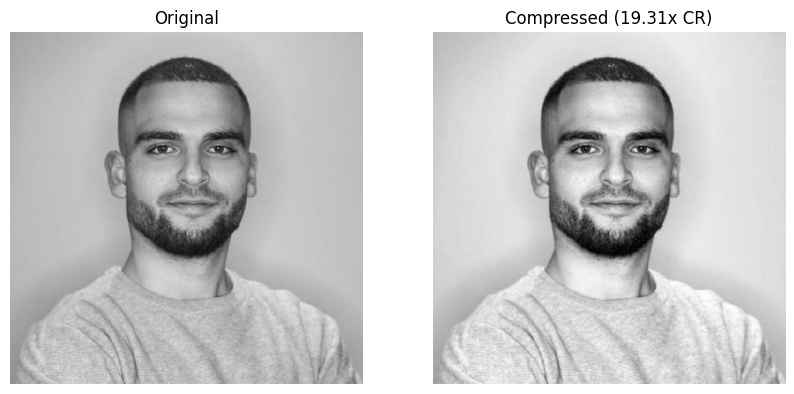

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap="gray")
ax[0].axis('off')
ax[0].set_title("Original")
ax[1].imshow(c_img[:], cmap="gray")
ax[1].axis('off')
ax[1].set_title(f"Compressed ({c_img.schunk.cratio:.2f}x CR)")

plt.show()


In [10]:
c_img.schunk.cratio

2.631333815144945

In [11]:
c_img[:]

array([[157.2875507 , 157.18165299, 156.81136347, ..., 176.26516691,
        175.6534719 , 174.67773349],
       [157.0170682 , 157.01127697, 156.91551886, ..., 175.99369646,
        175.96949345, 175.68912704],
       [157.34831253, 157.00445465, 157.13402086, ..., 175.81666296,
        176.18881675, 176.71152586],
       ...,
       [141.69959653, 141.50379385, 141.31403573, ..., 174.53281338,
        173.67941526, 172.55679184],
       [141.48049793, 141.13117501, 141.09489047, ..., 174.30989801,
        173.58550674, 173.08988429],
       [140.88196902, 140.8746062 , 140.74833887, ..., 174.071117  ,
        173.23936923, 172.67001126]])